$$\newcommand{\ketbra}[2]{\mathinner{|{#1}\rangle\,\langle{#2}|}}$$

# Problem 1
## Question
>1) 20 points
>
>Construct the operator $ P_3 = \ketbra{001}{001} + \ketbra{110}{110} $ using numpy and Qiskit's `Operator`. Similar to what you did in the lecture's notebook try to detect the bit flip error in the third qubit (use the result state $\ket{\psi_3}$ of task 8 of the lecture).


## Solution

*One important thing to note before proceeding is that in qiskit (and quantum computing in general), our qubit indices are different from the physics approach. i.e., in a physics class we would index a three qubit state as such $\ket{q_0q_1q_2}$ - with $q_0$ representing the Most Significant Bit, but in quantum computing we use the index convention $\ket{q_2q_1q_0}$ - with $q_2$ now representing the MSB. This difference is very confusing when not stated. In this notebook, the mathematics and writing are done using the physics convention of left-to-right naming, but the circuits are implemented with the computing convention of right-to-left naming*.

In [3]:
'''Imports'''
import numpy as np
from qiskit.quantum_info import Operator, Statevector
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt

Creating the projection operator $P_3$. 

The function defined below takes three single qubit states $\ket{a},\ket{b},\ket{c}$, takes their tensor product (kronecker product) 
$\ket{abc} = \ket{a}\otimes \ket{b} \otimes \ket{c},$
and then finds the projector $ \ketbra{abc}{abc}. $

In [4]:
zero = np.array([1,0])
one = np.array([0,1])

def get_projection(a: np.ndarray, b: np.ndarray, c: np.ndarray) -> np.ndarray:
    """
    Takes in three single qubit states, performs a tensor product between them and returns their projector. 
    """
    _state = np.kron(np.kron(a,b),c) 
    return np.outer(_state,_state)

proj_001 = get_projection(zero,zero,one)
proj_110 = get_projection(one,one,zero)
P_3 = Operator(proj_001 + proj_110)


The projection operator we constructed $ P_3 =  \ketbra{001}{001} + \ketbra{110}{110} $ is made to detect errors on the third qubit of the $\ket{\Phi^{+}}$ state we were using in the lecture. This means that if the state of the circuit does not match the original state **only** with a single qubit x-error on the third qubit, then the expected value of the projection will be zero. 

Using the code from task 8 of the lecture to generate the $\ket{\Phi^{+}}$ state with a simulated bitflip error on the third qubit

In [5]:
cq_3 = QuantumRegister(3, 'code_qubit')
qc_3 = QuantumCircuit(cq_3)
qc_3.h(cq_3[0])
qc_3.cx(cq_3[0], cq_3[1])
qc_3.cx(cq_3[0], cq_3[2])
qc_3.x(cq_3[0])
sv_flipped_3 = Statevector(qc_3)
sv_flipped_3.draw(output = 'latex')

<IPython.core.display.Latex object>

Calculating the expectation value of the circuit's state projected onto the error detection eigenspace we constructed yields a value of 1, meaning that the probability of measuring an error on the third qubit is $100\%$.

In [6]:
print(f"E of projection operator 3: {sv_flipped_3.expectation_value(P_3)}")

E of projection operator 3: (0.9999999999999998+0j)


However, in the quantum realm, bit-flip errors (x-errors) are not binary as in the classical case, they can take on any continuous angle. To show this, let's parameterize the error circuit from before.

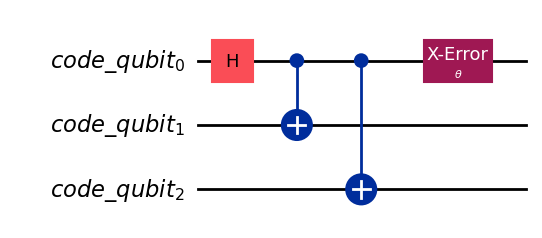

In [7]:
theta = Parameter(r'$\theta$')
cq_x = QuantumRegister(3, 'code_qubit')
qc_x = QuantumCircuit(cq_x)
qc_x.h(cq_x[0])
qc_x.cx(cq_x[0], cq_x[1])
qc_x.cx(cq_x[0], cq_x[2])
qc_x.rx(theta,cq_x[0],r'X-Error')
qc_x.draw("mpl")

*Remember, it's saying qubit 0, but this is the opposite way around! This is an x-rotation on the third qubit.*

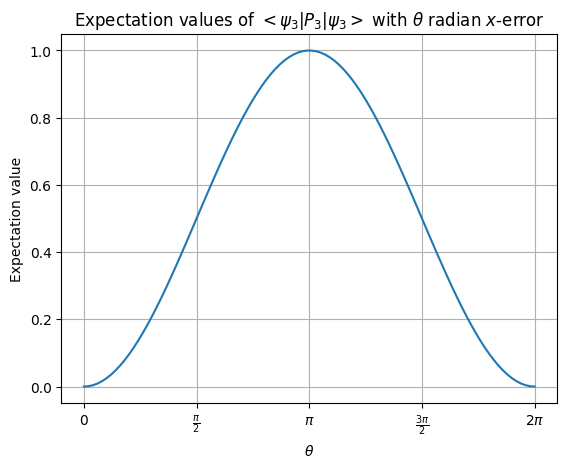

In [8]:
phases = np.linspace(0,2*np.pi,100)
error_probs_3 = []
for ph in phases:
    phase_error_circ = qc_x.assign_parameters({theta: ph})
    phase_error_state = Statevector(phase_error_circ)
    error_probs_3.append(phase_error_state.expectation_value(P_3))


plt.plot(phases, np.real(error_probs_3)) #The expectation values are all real, taking the real part avoids warnings

'''Plot settings'''
plt.ylabel(r'Expectation value')
plt.xlabel(r'$\theta$')
plt.grid(True)
plt.xticks(
    np.linspace(0,2*np.pi,5), 
    [r'$0$',r'$\frac{\pi}{2}$',r'$\pi$',r'$\frac{3\pi}{2}$',r'$2\pi$'],
    )
_ = plt.title(r'Expectation values of $<\psi_{3}| P_{3} |\psi_{3}> $ with $\theta$ radian $x$-error')


As can be seen, the expected value varies with the sine of the angle of the x-error.

---

# Problem 2
## Question
>2) 50 points
>
>Show mathematically that $\bra{\psi_3}P_3\ket{\psi_3}=1$.

## Solution

To show this, I'm going to show it for the continuous case where 
$$\large
\ket{\psi_{3}(\theta)} = \frac{1}{\sqrt{2}}\left[\ket{00} \otimes (R_x(\theta)\ket{0}) + \ket{11} \otimes (R_x(\theta)\ket{1})\right].
$$

We first need to find the expression for $R_x(\theta)$. This operator is represented by the following matrix:
$$\large
R_x(\theta) = \begin{bmatrix}
\cos\left(\frac{\theta}{2}\right) & -i\sin\left(\frac{\theta}{2}\right)\\
-i\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right)
\end{bmatrix}.
$$


Applying this matrix to the $\ket{0}$ and $\ket{1}$ states gives us
$$
\begin{matrix}
R_x(\theta)\ket{0} = \cos\left(\frac{\theta}{2}\right)\ket{0} - i\sin\left(\frac{\theta}{2}\right)\ket{1},
\\\\ \text{and} \\\\
R_x(\theta)\ket{1} = -i\sin\left(\frac{\theta}{2}\right)\ket{0} + \cos\left(\frac{\theta}{2}\right)\ket{1}.
\end{matrix}
$$

Plugging this into our expression for $\ket{\psi_{3}(\theta)}$:
$$
\ket{\psi_3(\theta)} = \frac{1}{\sqrt{2}}\left[\cos\left(\frac{\theta}{2}\right)\left( \ket{000} + \ket{111} \right) - i\sin\left(\frac{\theta}{2}\right)\left(\ket{001} + \ket{110}\right)\right],
$$
and
$$
\bra{\psi_{3}(\theta)} = \frac{1}{\sqrt{2}}\left[\cos\left(\frac{\theta}{2}\right)(\bra{000} + \bra{111}) + i\sin\left(\frac{\theta}{2}\right)(\bra{001} + \bra{110})\right].
$$

If you'll notice what this expression says, the $\cos\left(\frac{\theta}{2}\right)$ term is our original state, and the $-i\sin\left(\frac{\theta}{2}\right)$ term is our bit-flipped state. It's a superposition of flipped and not-flipped! One important thing to note is that when $\theta=\pi$ (which is the state with the bit flipped fully), we get
$$
\ket{\psi_3(\pi)} = -\frac{i}{\sqrt{2}}(\ket{001} + \ket{110}),
$$ 
which is the state we expect but with a phase of $e^{-i \pi}$. 
This isn't an issue, however, because upon measurement, there is no way to distinguish $\ket{\psi}$ and $e^{i\varphi}\ket{\psi}$. Thus, this term (known as the **global phase**) can just be ignored.

Now calculating the expectation value:
$$\large
\begin{align*}
    \bra{\psi_{3}(\theta)}P_{3}\ket{\psi_{3}(\theta)} = &~\frac{1}{\sqrt{2}}\left[\cos\left(\frac{\theta}{2}\right)(\bra{000} + \bra{111}) + i\sin\left(\frac{\theta}{2}\right)(\bra{001} + \bra{110})\right]
    \\  &\times (\ketbra{001}{001} + \ketbra{110}{110})
    \\  &\times \frac{1}{\sqrt{2}}\left[\cos\left(\frac{\theta}{2}\right)\left( \ket{000} + \ket{111} \right) - i\sin\left(\frac{\theta}{2}\right)\left(\ket{001} + \ket{110}\right)\right]
    \\ \\
    = ~&\frac{1}{2}\left(i\sin\left(\frac{\theta}{2}\right)\right)\left(-i\sin\left(\frac{\theta}{2}\right)\right)(\braket{001|001}\braket{001|001} + \braket{110|110}\braket{110|110})
    \\ \\
    = ~&\frac{1}{2}\sin^{2}\left(\frac{\theta}{2}\right)(1+1)
    \\ \\
    = ~&\sin^{2}\left(\frac{\theta}{2}\right)
    \\ \\
    = ~&\frac{1-\cos(\theta)}{2}.
\end{align*}
$$

As you can see, if you plot this as a function, you get the same graph as with the plot as before!

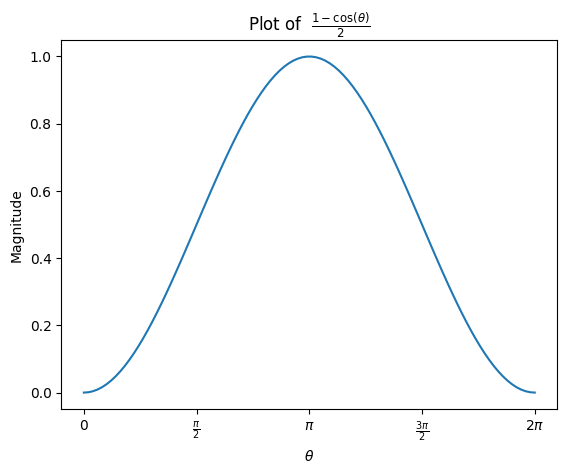

In [9]:
'''Plotting our mathematically calculated expressions for the expected value'''
exp_values = [(1-np.cos(theta))/2 for theta in phases]

plt.plot(phases,exp_values)

'''Plot settings'''
plt.ylabel(r'Magnitude')
plt.xlabel(r'$\theta$')
plt.xticks(
    np.linspace(0,2*np.pi,5), 
    [r'$0$',r'$\frac{\pi}{2}$',r'$\pi$',r'$\frac{3\pi}{2}$',r'$2\pi$']
    )
_ = plt.title(r'Plot of  $\frac{1-\cos(\theta)}{2}$')

Now the question is specifically asking for the expectation value for $\theta=\pi$. Plugging this into our expression gives us that
$$
\bra{\psi_3(\pi)}P_{3}\ket{\psi_{3}(\pi)} = \frac{1-\cos(\pi)}{2} = \frac{1 - (-1)}{2} = \frac{2}{2} = 1.
$$

---

# Problem 3
## Question
>3) 30 points
>
>Show that $P_3$ is not unitary - do you have an intuition why?

## Solution

$P_{3}$ is a projection which, by definition follows the identities that $P_{3}=P_{3}^{\dagger}$ and $P_{3}^{2}=P_{3}$. 

This is a direct contradiction to the definition of a Unitary operator where $\mathcal{U}\mathcal{U}^{\dagger} = \mathbb{I}$.

As for a more concrete intuition in terms of the outcome of the projection, a unitary operator has the property where it is its own inverse. In fact, all single qubit unitary operators used in quantum theory are part of a special mathematical group called SU(2). This is a fancy way of saying that all 2x2 Unitary matrices represent rotations and reflections on the Block sphere. This is important for quantum gates as this means that they are **time-reversible**. It also means that if you apply them twice, you will return your qubit back to its original state. 

A projection however, *cannot* be represented as a rotation/reflection and instead *projects* a given state onto a certain basis. This projection is **irreversible**. To show an example of why this is, let's define a projection $P=\ketbra{0}{0}$ and the quantum state $\ket{\psi} = \alpha\ket{0} + \beta\ket{1}$. If we apply the projection we get
$$
P\ket{\psi} = \ket{0}(\alpha\braket{0|0} + \beta\braket{0|1}) = \alpha\ket{0}.
$$
The $\ket{1}$ was completely lost! and if we want to apply the projector again (which would normally revert the state back for a unitary operator), we get 
$$
P(P\ket{\psi}) = P^{2}\ket{\psi} = P\ket{\psi}.
$$
There is no way to get the state back!

Thus, no projection can be Unitary, and no Unitary can be a projection (given that $P \neq \mathbb{I}$).

For rigor's sake, let's show that $P_{3}$ is in fact a Projection and thus is non-Unitary. We need to show that $P_{3}=P_{3}^{\dagger}$, and that $P_{3}=P_{3}^{2}$.

$$
P_{3}^{\dagger} = (\ketbra{001}{001})^{\dagger} + (\ketbra{110}{110})^{\dagger} = \ketbra{001}{001} + \ketbra{110}{110} = P_{3}.
$$

$$\large
\begin{align*}
    P_{3}^{2} &= (\ketbra{001}{001} + \ketbra{110}{110})(\ketbra{001}{001} + \ketbra{110}{110})
    \\ &= \ket{001}(\braket{001|001}\bra{001} + \braket{001|110}\bra{110}) + \ket{110}(\braket{110|001}\bra{001} + \braket{110|110}\bra{110})
    \\ &= \ket{001}(\bra{001} + 0) + \ket{110}(0 + \bra{110})
    \\ &= \ketbra{001}{001} + \ketbra{110}{110}
    \\ &= P.
\end{align*}
$$